# Figure 2

In [1]:
import pyleoclim as pyleo
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import ammonyte as amt
from tqdm import tqdm

ModuleNotFoundError: No module named 'pyleoclim'

In [ ]:
#We suppress warnings for these notebooks for presentation purposes. Best practice is to not do this though.
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Defining group lists for easy loading
group_names = ['ODP 925','ODP 927','ODP 929','ODP 846','ODP 849']

Loading time series from [LR04 stack data](https://lorraine-lisiecki.com/LR04cores.zip). The webpage with the data can be found [here](https://lorraine-lisiecki.com/stack.html).

/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_849/4038038886.py:16: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  series = pyleo.Series(value=d18O,


Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order


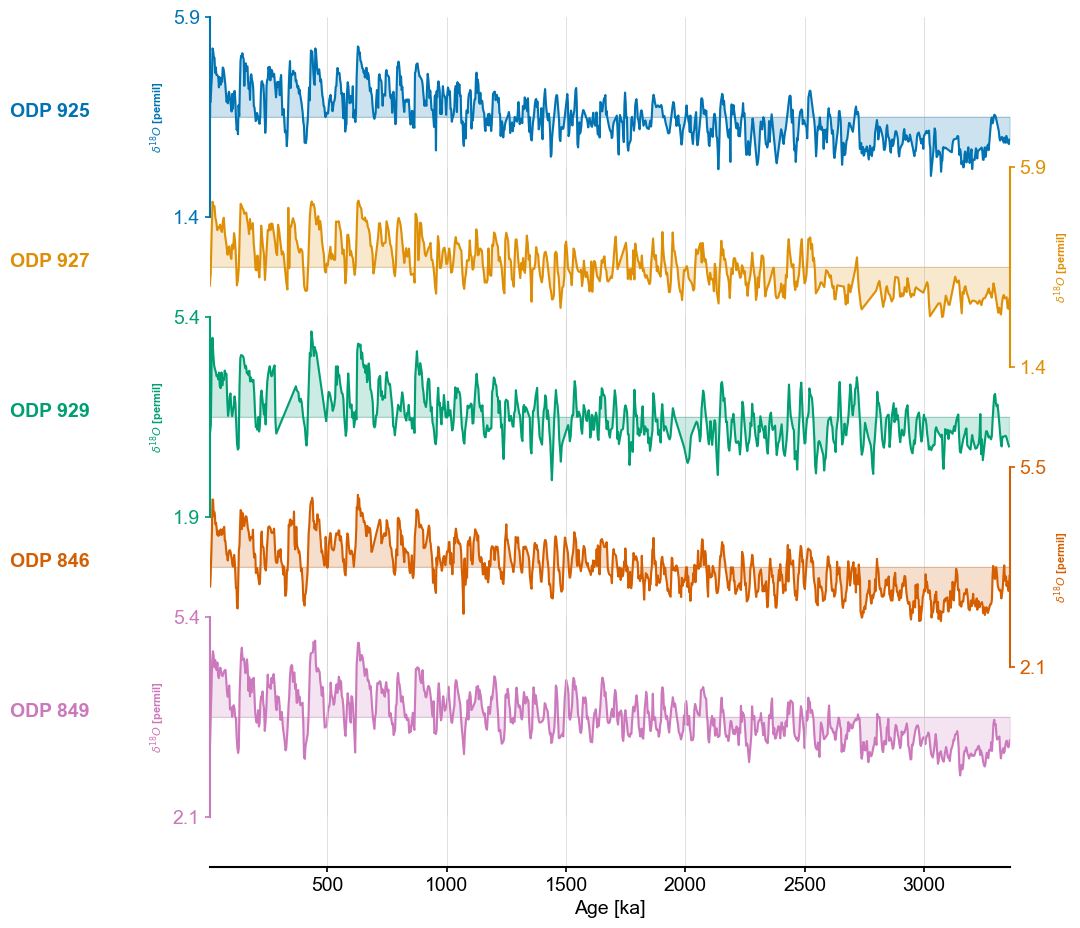

In [3]:
series_list = []
color_list = sns.color_palette('colorblind')

for name in group_names:
    with open('./data/LR04cores_spec_corr/'+name[-3:]+'_LR04age.txt','rb') as handle:
        lines = handle.readlines()
        time = []
        d18O = []
        for x in lines:
            line_time = float(format(float(x.decode().split()[1]),'10f'))
            line_d18O = float(format(float(x.decode().split()[2]),'10f'))
            #There is a discontinuity in 927 around 4000 ka, we'll just exclude it
            if line_time <= 4000:
                time.append(line_time)
                d18O.append(line_d18O)
        series = pyleo.Series(value=d18O,
                              time=time,
                              label=name,
                              time_name='Yr',
                              time_unit='ka',
                              value_name=r'$\delta^{18}O$',
                              value_unit='permil')
    series_list.append(series)
    
max_time = min([max(series.time) for series in series_list])
min_time = max([min(series.time) for series in series_list])

ms = pyleo.MultipleSeries([series.slice((min_time,max_time)).interp() for series in series_list])
fig,ax = ms.stackplot(colors=color_list[:len(ms.series_list)],figsize=(8,10))

In [4]:
def detect_transitions(series,transition_interval=None):
    '''Function to detect transitions across a confidence interval
    
    Parameters
    ----------
    
    series : pyleo.Series, amt.Series
        Series to detect transitions upon
        
    transition_interval : list,tuple
        Upper and lower bound for the transition interval
    
    Returns
    -------
    
    transitions : list
        Timing of the transitions of the series across its confidence interval
    '''
    series_fine = series.interp(step=1)
    
    if transition_interval is None:
        upper, lower = amt.utils.sampling.confidence_interval(series)
    else:
        upper, lower = transition_interval

    above_thresh = np.where(series_fine.value > upper,1,0)
    below_thresh = np.where(series_fine.value < lower,1,0)

    transition_above = np.diff(above_thresh)
    transition_below = np.diff(below_thresh)

    upper_trans = series_fine.time[1:][np.diff(above_thresh) != 0]
    lower_trans = series_fine.time[1:][np.diff(below_thresh) != 0]

    full_trans = np.zeros(len(transition_above))

    last_above = 0
    last_below = 0
    for i in range(len(transition_above)):
        above = transition_above[i]
        below = transition_below[i]
        if above != 0:
            if last_below+above == 0:
                loc = int((i+below_pointer)/2)
                full_trans[loc] = 1
                last_below=0
            last_above = above
            above_pointer = i
        if below != 0:
            if last_above + below == 0:
                loc = int((i+above_pointer)/2)
                full_trans[loc] = 1
                last_above=0
            last_below = below
            below_pointer = i

    transitions = series_fine.time[1:][full_trans != 0]
    
    return transitions

Carrying out LERM analysis

In [5]:
lp_rm = {}
lp_fi = {}

m = 13 # Embedding dimension

for idx,series in enumerate(ms.common_time().series_list):
    series = series.convert_time_unit('Years').interp().detrend(method='savitzky-golay')
    amt_series = amt.Series(
        time=series.time,
        value=series.value,
        time_name = series.time_name,
        value_name = series.value_name,
        time_unit = series.time_unit,
        value_unit = series.value_unit,
        label = series.label,
        clean_ts=False,
        sort_ts=None
    )
    td = amt_series.embed(m=m) # Tau is selected according to first minimum of mutual information
    print(f'{series.label} tau is : {td.tau}')
    eps = td.find_epsilon(eps = 1,target_density=.05,tolerance=.01) # Find epsilon value that gives us recurrence density of 5% (1 is the starting value we use for epsilon as a first guess)
    rm = eps['Output']
    lp_series = rm.laplacian_eigenmaps(w_size = 50,w_incre = 5) # Window size = 50, window increment = 5
    lp_series = lp_series.convert_time_unit('ka')
    lp_fi[series.label] = lp_series

/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_849/1277079953.py:8: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  amt_series = amt.Series(


ODP 925 tau is : 6
Initial density is 0.0230
Initial density is not within the tolerance window, searching...
Epsilon: 1.0000, Density: 0.0230
Epsilon: 1.1348, Density: 0.0535
Epsilon: 1.1348, Density: 0.0535.


/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: No time_name parameter provided. Assuming "Time".
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_849/1277079953.py:8: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  amt_series = amt.Series(


ODP 927 tau is : 4
Initial density is 0.0347
Initial density is not within the tolerance window, searching...
Epsilon: 1.0000, Density: 0.0347
Epsilon: 1.0763, Density: 0.0535
Epsilon: 1.0763, Density: 0.0535.


/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: No time_name parameter provided. Assuming "Time".
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_849/1277079953.py:8: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  amt_series = amt.Series(


ODP 929 tau is : 4
Initial density is 0.0406
Initial density is within the tolerance window!


/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: No time_name parameter provided. Assuming "Time".
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_849/1277079953.py:8: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  amt_series = amt.Series(


ODP 846 tau is : 7
Initial density is 0.1115
Initial density is not within the tolerance window, searching...
Epsilon: 0.3852, Density: 0.0014
Epsilon: 0.8709, Density: 0.0460
Epsilon: 0.8709, Density: 0.0460.


/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: No time_name parameter provided. Assuming "Time".
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_849/1277079953.py:8: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  amt_series = amt.Series(


ODP 849 tau is : 5
Initial density is 0.1097
Initial density is not within the tolerance window, searching...
Epsilon: 0.4032, Density: 0.0017
Epsilon: 0.8860, Density: 0.0491
Epsilon: 0.8860, Density: 0.0491.


/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True. In a future release this will be changed to False.
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)
/Users/alexjames/Documents/GitHub/Ammonyte/ammonyte/core/rqa_res.py:22: UserWarning: No time_name parameter provided. Assuming "Time".
  super().__init__(time,value,time_name,time_unit,value_name,value_unit,label,sort_ts=None)


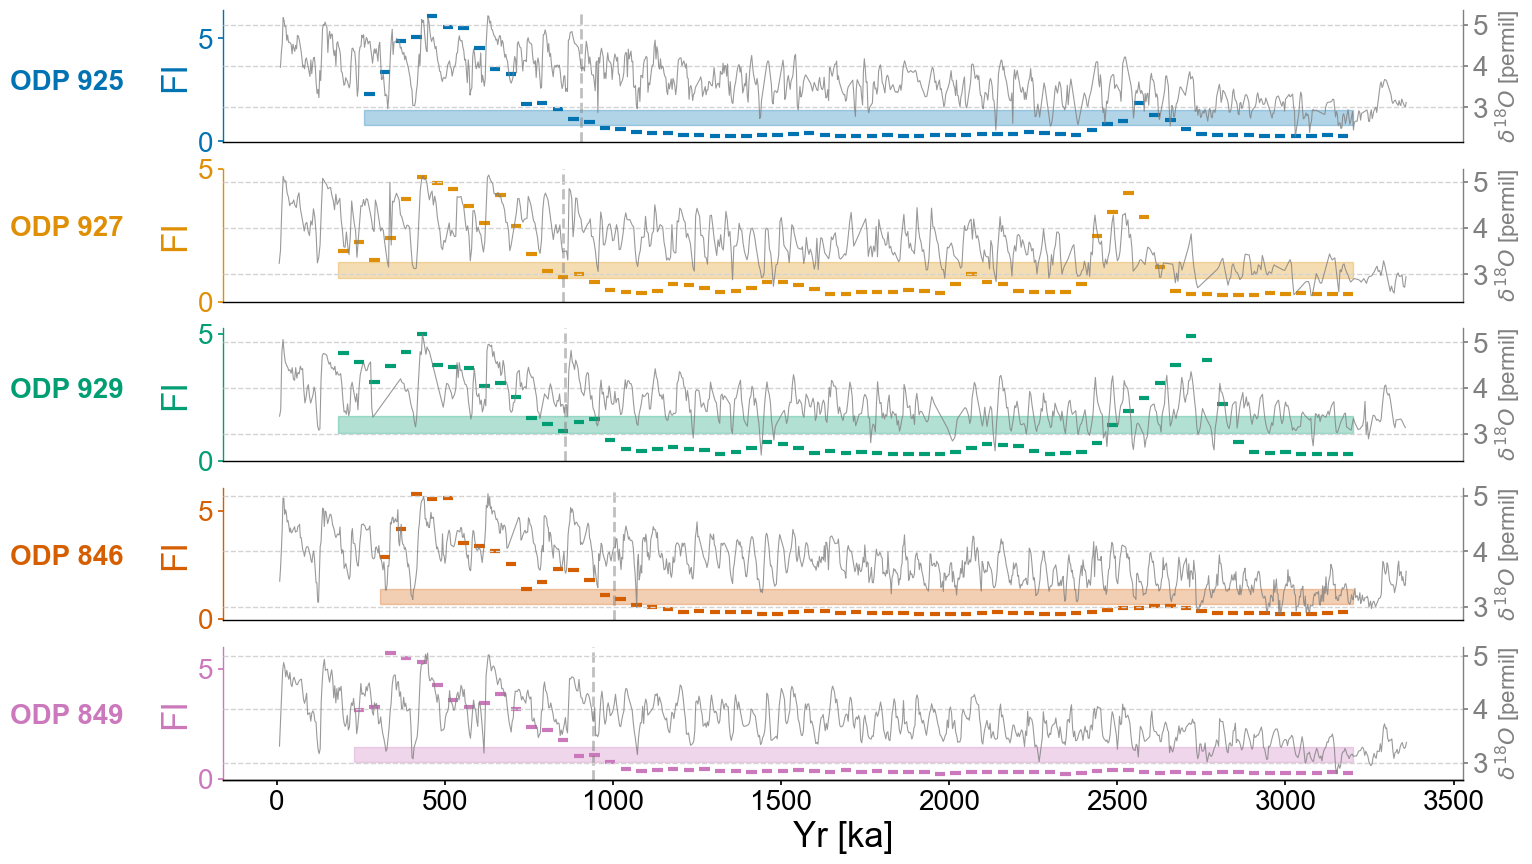

In [6]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig,axes = plt.subplots(nrows=len(group_names),ncols=1,sharex=True,figsize=(16,10))
transition_timing = []

for idx,site in enumerate(group_names):
    ts = lp_fi[site]
    ts.label = lp_series.label
    ts.value_name = 'FI'
    ts.value_unit = None
    ts.time_name = 'Yr'
    ts.time_unit = 'ka'

    ax = axes[idx]
    ts_smooth = amt.utils.fisher.smooth_series(series=ts,block_size=3) #Using a block size of 3 for smoothing the Fisher information
    upper, lower = amt.utils.sampling.confidence_interval(series=ts,upper=95,lower=5,w=50,n_samples=10000) #Calculating the bounds for our confidence interval using default values 
    transitions=detect_transitions(ts_smooth,transition_interval=(upper,lower))
    
    transition_timing.append(transitions[0])

    ts.confidence_smooth_plot(
        ax=ax,
        background_series = ms.series_list[idx],
        transition_interval=(upper,lower),
        block_size=3,
        color=color_list[idx],
        figsize=(12,6),
        legend=True,
        lgd_kwargs={'loc':'upper left'},
        hline_kwargs={'label':None},
        background_kwargs={'ylabel':'$\delta^{18}O$ [permil]','legend':False,'linewidth':.8,'color':'grey','alpha':.8})

    ax.axvline(transition_timing[idx],color='grey',linestyle='dashed',alpha=.5)
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    ax.text(x=-.08, y = 2.5, s = site, horizontalalignment='right', transform=trans, color=color_list[idx], weight='bold',fontsize=20)
        
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_label_position('left')
    ax.yaxis.tick_left()
    ax.get_legend().remove()
    ax.set_title(None)
    ax.grid(visible=False,axis='y')
    if idx != len(group_names)-1:
        ax.set_xlabel(None)
        ax.spines[['bottom']].set_visible(False)
        ax.tick_params(bottom=False)
    ax.xaxis.label.set_fontsize(25)
    ax.yaxis.label.set_fontsize(25)
    ax.set_yticks(ticks=np.array([0,5]))

Checking the stats of the transition timings:

In [7]:
np.mean(transition_timing)

910.7573936631004

In [8]:
np.std(transition_timing)

56.90001486147384